## Import and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import os

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# set DATA_PATH
data_dir = '/opt/ml/input/data/train_dataset'
DATA_PATH = os.path.join(data_dir, 'train_data.csv')
print(DATA_PATH)
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

/opt/ml/input/data/train_dataset/train_data.csv
CPU times: user 5.6 s, sys: 772 ms, total: 6.37 s
Wall time: 6.44 s


In [3]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## 기본적인 내용 파악

`userID` : 사용자의 고유 번호. 총 7,442명의 학생.   
`assessmentItemID` 사용자가 푼 문항의 일련 번호.   
`testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호.   
`answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터.   
`Timestamp` 사용자가 문항을 푼 시간 정보.   
`KnowledgeTag` 사용자가 푼 문항의 고유 태그. 

### 특성의 기본 정보

In [4]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


## 일련 번호 분석

### 첫 번째 단어 A
A 밖에 없는 것을 확인할 수 있음

In [5]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

### 문항 일련 번호 내 시험지 번호

In [6]:
sum(df['assessmentItemID'].apply(lambda x: x[1:7]) == df['testId'].apply(lambda x: x[1:4]+x[7:]))

2266586

### 시험지 번호 가운데 3자리 모두 000

In [7]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

## 기술 통계량 분석

In [8]:
def percentile(s):
    return np.sum(s) / len(s)

### 사용자 분석

In [9]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


## 사용자별 푼 문항 개수

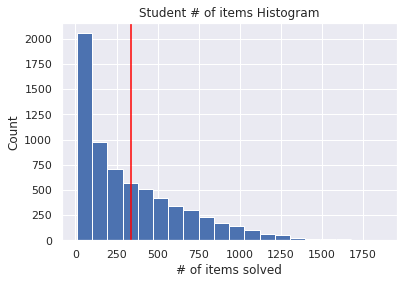

In [10]:
fig, ax = plt.subplots()
stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)
ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

## 사용자별 정답률

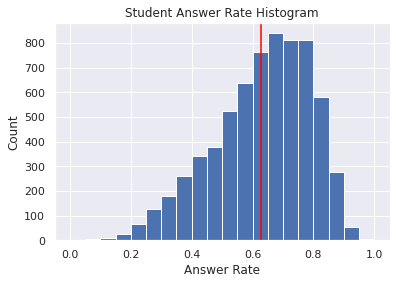

In [11]:
fig, ax = plt.subplots()
stu_groupby['answerCode'].hist(bins=20)
ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

# assessementID 분석

## 문항 별 정답률 분석

In [12]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


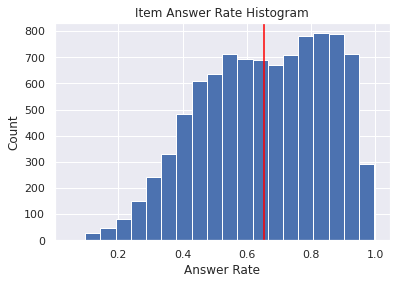

In [13]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

## difficulty 분석

In [87]:
temp = df
temp['ass_pre'] = temp['assessmentItemID'].apply(lambda x:x[1:4])

ass_pre_std = temp.groupby('ass_pre')['answerCode'].std().reset_index()

In [88]:
ass_pre_std

,ass_pre,answerCode
0,010,0.399342
1,020,0.439944
2,030,0.457275
3,040,0.464891
4,050,0.474311
5,060,0.454118
6,070,0.499522
7,080,0.499994
8,090,0.497491


In [89]:
ass_pre_mean = temp.groupby('ass_pre')['answerCode'].mean().reset_index()

Text(0.5, 1.0, 'assessmentItemID_pre - Answer Rate Mean')

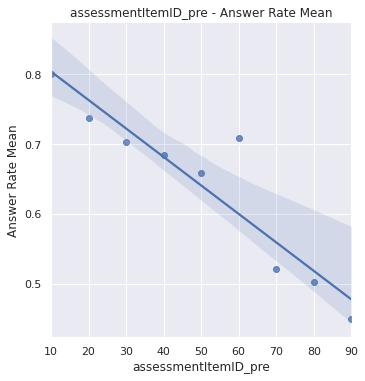

In [93]:
ass_pre_mean['ass_pre'] = ass_pre_mean['ass_pre'].apply(lambda x:int(x))
g = sns.lmplot(data=ass_pre_mean, x='ass_pre', y='answerCode')
g.set_xlabels('assessmentItemID_pre')
g.set_ylabels('Answer Rate Mean')
ax = plt.gca()
ax.set_title('assessmentItemID_pre - Answer Rate Mean')

대체로 번호가 커질 수록 평균 정답률이 낮아지는 경향을 보인다 -> 난이로라고 봐도 될 듯 싶다

In [94]:
df['difficulty'] = temp['assessmentItemID'].apply(lambda x:x[1:4])

# testId 분석

## 시험지 별 정답률

In [96]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


## 각 testID 별 정답률

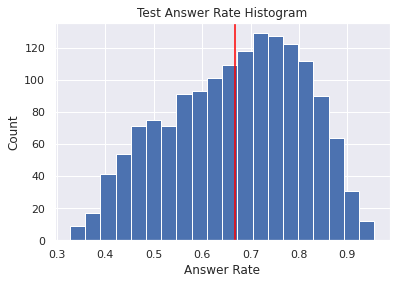

In [97]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

In [159]:
tesmp_test_df = df
tesmp_test_df['testId_str'] = tesmp_test_df['testId'].apply(lambda x:x[1:])
tesmp_test_df['testId_str']

0          060000001
1          060000001
2          060000001
3          060000001
4          060000001
             ...    
2266581    030000071
2266582    040000165
2266583    040000165
2266584    040000165
2266585    040000165
Name: testId_str, Length: 2266586, dtype: object

In [160]:
tesmp_test_df['testId_pre'] = tesmp_test_df.testId_str.map(lambda x: x[:3])
tesmp_test_df['testId_mid'] = tesmp_test_df.testId_str.map(lambda x: x[3:6]) #000
tesmp_test_df['testId_post'] = tesmp_test_df.testId_str.map(lambda x: x[-3:])

In [161]:
print(tesmp_test_df['testId_pre'].describe())
print(tesmp_test_df['testId_pre'].unique())
print(tesmp_test_df['testId_pre'].nunique())

count     2266586
unique          9
top           070
freq       279164
Name: testId_pre, dtype: object
['060' '080' '020' '040' '090' '030' '050' '010' '070']
9


In [162]:
print(tesmp_test_df['testId_post'].describe())
print(tesmp_test_df['testId_post'].unique())
print(tesmp_test_df['testId_post'].nunique())

count     2266586
unique        198
top           017
freq        17739
Name: testId_post, dtype: object
['001' '003' '005' '007' '002' '009' '016' '004' '006' '018' '020' '008'
 '010' '022' '012' '014' '024' '031' '033' '035' '037' '039' '041' '043'
 '036' '052' '054' '038' '056' '058' '060' '040' '062' '042' '070' '072'
 '074' '044' '076' '078' '046' '048' '085' '087' '089' '091' '093' '094'
 '095' '096' '097' '080' '099' '082' '101' '084' '103' '086' '105' '088'
 '107' '090' '092' '098' '172' '121' '100' '123' '125' '102' '174' '181'
 '127' '129' '182' '131' '183' '119' '115' '192' '108' '112' '114' '118'
 '120' '128' '013' '015' '017' '019' '021' '049' '051' '063' '065' '073'
 '075' '081' '083' '011' '023' '025' '026' '034' '027' '028' '029' '030'
 '032' '050' '047' '155' '156' '068' '157' '158' '064' '066' '160' '059'
 '161' '162' '163' '164' '165' '104' '184' '106' '185' '186' '132' '133'
 '134' '195' '135' '196' '152' '153' '154' '197' '198' '159' '045' '109'
 '111' '113' '117' 

In [165]:
groupby_testId_pre = df.groupby('testId_pre').agg({
    'KnowledgeTag' : 'count',
    'answerCode': percentile
}).reset_index()

groupby_testId_post = df.groupby('testId_post').agg({
    'KnowledgeTag' : 'count',
    'answerCode': percentile
}).reset_index()

groupby_testId = df.groupby('testId_str').agg({
    'KnowledgeTag' : 'count',
    'answerCode': percentile
}).reset_index()

In [166]:
groupby_testId_pre

,testId_pre,KnowledgeTag,answerCode
0,10,272082,0.800876
1,20,268327,0.737593
2,30,273762,0.702238
3,40,267323,0.684056
4,50,275773,0.658208
5,60,264434,0.709232
6,70,279164,0.521876
7,80,246336,0.502598
8,90,119385,0.449948


In [167]:
groupby_testId_post

,testId_post,KnowledgeTag,answerCode
0,1,14911,0.710348
1,2,12390,0.774011
2,3,16970,0.626930
3,4,12332,0.678803
4,5,16325,0.617519
...,...,...,...
193,194,2596,0.694145
194,195,4417,0.835409
195,196,1304,0.895706
196,197,2973,0.757820


## 각 testId_pre 갯수

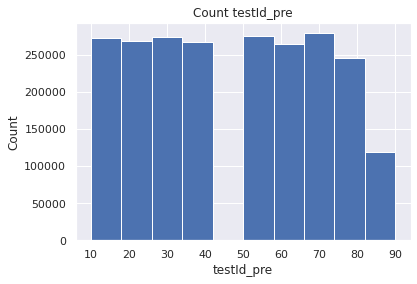

In [175]:
fig, ax = plt.subplots()
df['testId_pre'].sort_values().hist()
ax.set_title('Count testId_pre')
ax.set_xlabel('testId_pre')
ax.set_ylabel('Count')
ax.grid(b=True)

## 각 testId_post 갯수

Text(0, 0.5, 'count')

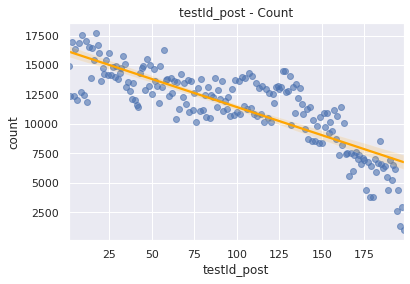

In [176]:
fig, ax = plt.subplots()
sns.regplot(data=groupby_testId_post.sort_values('testId_post'), x='testId_post', y='KnowledgeTag',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'testId_post - Count')
ax.set_xlabel('testId_post')
ax.set_ylabel('count')

## 각 testId_pre 정답률

Text(0, 0.5, 'answerCodeRate')

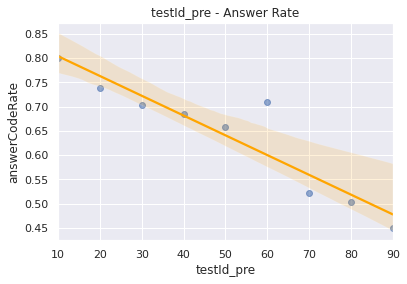

In [177]:

fig, ax = plt.subplots()
sns.regplot(data=groupby_testId_pre.sort_values(by='testId_pre'), x='testId_pre', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)
ax.set_title(f'testId_pre - Answer Rate')
ax.set_xlabel('testId_pre')
ax.set_ylabel('answerCodeRate')

## 각 testId_post 정답률

Text(0, 0.5, 'answerCodeRate')

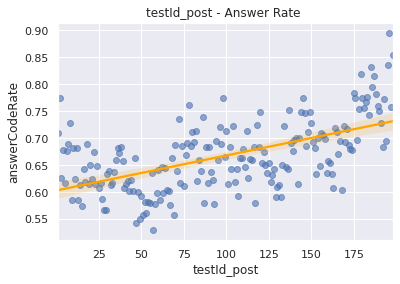

In [178]:

fig, ax = plt.subplots()
sns.regplot(data=groupby_testId_post.sort_values('testId_post'), x='testId_post', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'testId_post - Answer Rate ')
ax.set_xlabel('testId_post')
ax.set_ylabel('answerCodeRate')

In [174]:
print_quantile(groupby_testId_post['answerCode'])

min :  0.5291073738680466
10% :  0.5865413285928879
25% :  0.6176770165248938
50% :  0.6625598789482764
75% :  0.7049407666882128
80% :  0.7188520770753777
85% :  0.7370793959767343
90% :  0.7560250923080452
max :  0.8957055214723927
mean :  0.6677808297996216


## 많이 풀린 시험지의 정답 비율?

In [179]:
df['testId_str'].unique()

array(['060000001', '060000003', '060000005', ..., '010000178',
       '010000189', '010000180'], dtype=object)

In [180]:
problemPerTest = df.groupby('testId_str').agg({
    'assessmentItemID' : 'nunique',
    'answerCode': percentile,
    'testId' : 'count'
}).reset_index()

In [181]:
temp = []
for i, row in problemPerTest.iterrows():
    temp.append(row.testId//row.assessmentItemID)
problemPerTest['NSolve'] = temp

problemPerTest['NSolve'].describe()

count    1537.000000
mean      242.422251
std        69.688280
min        43.000000
25%       222.000000
50%       262.000000
75%       272.000000
max       454.000000
Name: NSolve, dtype: float64

## 시험지별 문항 수에 따른 정답률?

Text(0, 0.5, 'answerCodeRate')

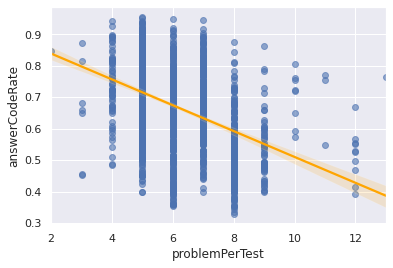

In [182]:
fig, ax = plt.subplots()
sns.regplot(data=problemPerTest, x='assessmentItemID', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_xlabel('problemPerTest')
ax.set_ylabel('answerCodeRate')

## 많이 풀린 시험지의 정답 비율?

Text(0, 0.5, 'answerCodeRate')

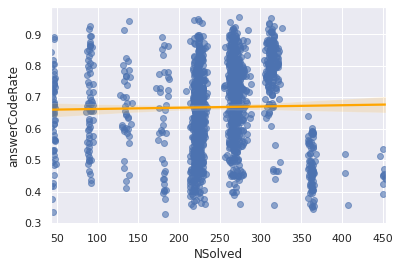

In [184]:
fig, ax = plt.subplots()
sns.regplot(data=problemPerTest, x='NSolve', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)
ax.set_xlabel('NSolved')
ax.set_ylabel('answerCodeRate')

## 문항을 더 많이 푼 학생이 문제를 더 맞추는가?

Text(0.5, 1.0, '# of Questions - Answer Rate')

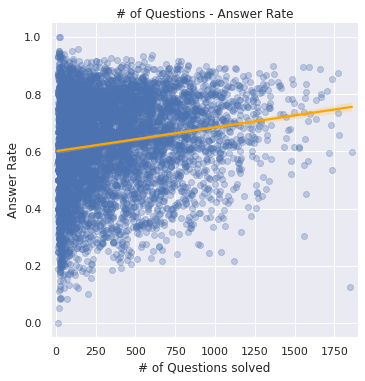

In [189]:
g = sns.lmplot(data=stu_groupby, x='assessmentItemID', y='answerCode',
              scatter_kws={'alpha':0.3}, line_kws={"color": "orange"})
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))
ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [190]:
print(f"Correlation between # of Tags being solved - Answer Rate: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

Correlation between # of Tags being solved - Answer Rate: 0.168


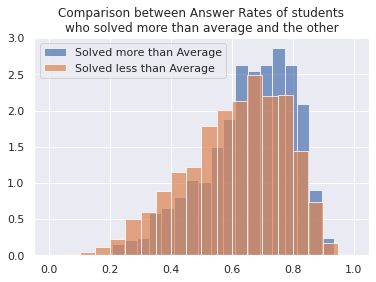

In [18]:
fig, ax = plt.subplots()
ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average')
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average')
ax.legend()

## 더 많이 노출된 태그가 정답률이 더 높은가?

In [19]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


Text(0.5, 1.0, '# of Tags Exposed - Answer Rate')

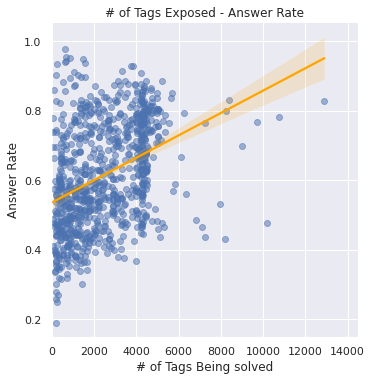

In [20]:
g = sns.lmplot(data=tag_groupby, x='userID', y='answerCode',
              scatter_kws={'alpha':0.5}, line_kws={"color": "orange"})
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))
ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate')

In [21]:
print(f"Correlation between # of Tags being solved - Answer Rate: {tag_groupby.corr()['answerCode']['userID']:.3f}")

Correlation between # of Tags being solved - Answer Rate: 0.376


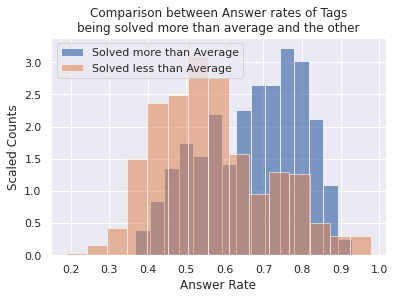

In [22]:
fig, ax = plt.subplots()
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')
tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average')
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average')
ax.legend()

## 문항을 풀수록 실력이 늘어나는가?

In [191]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

푼 문항의 갯수가 중앙값 부근인 10명의 학생들

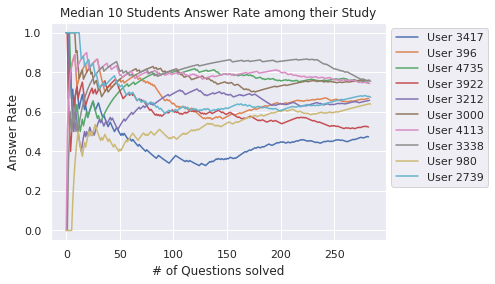

In [24]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

정답률이 중앙값 부근인 10명의 학생들

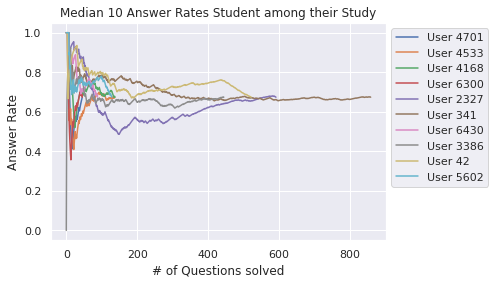

In [25]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

Window_size 적용

In [26]:
def plot_rolled_answerrate(userID, ax, window_sizes=[70, 100, 120]):
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        (df[df.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop=True) / wdw_sz).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

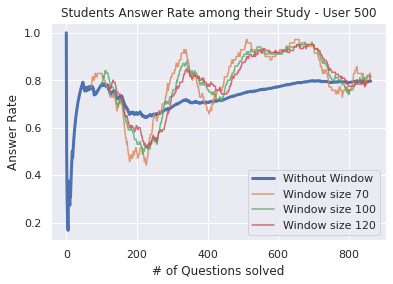

In [27]:
fig, ax = plt.subplots()
plot_rolled_answerrate(500, ax)

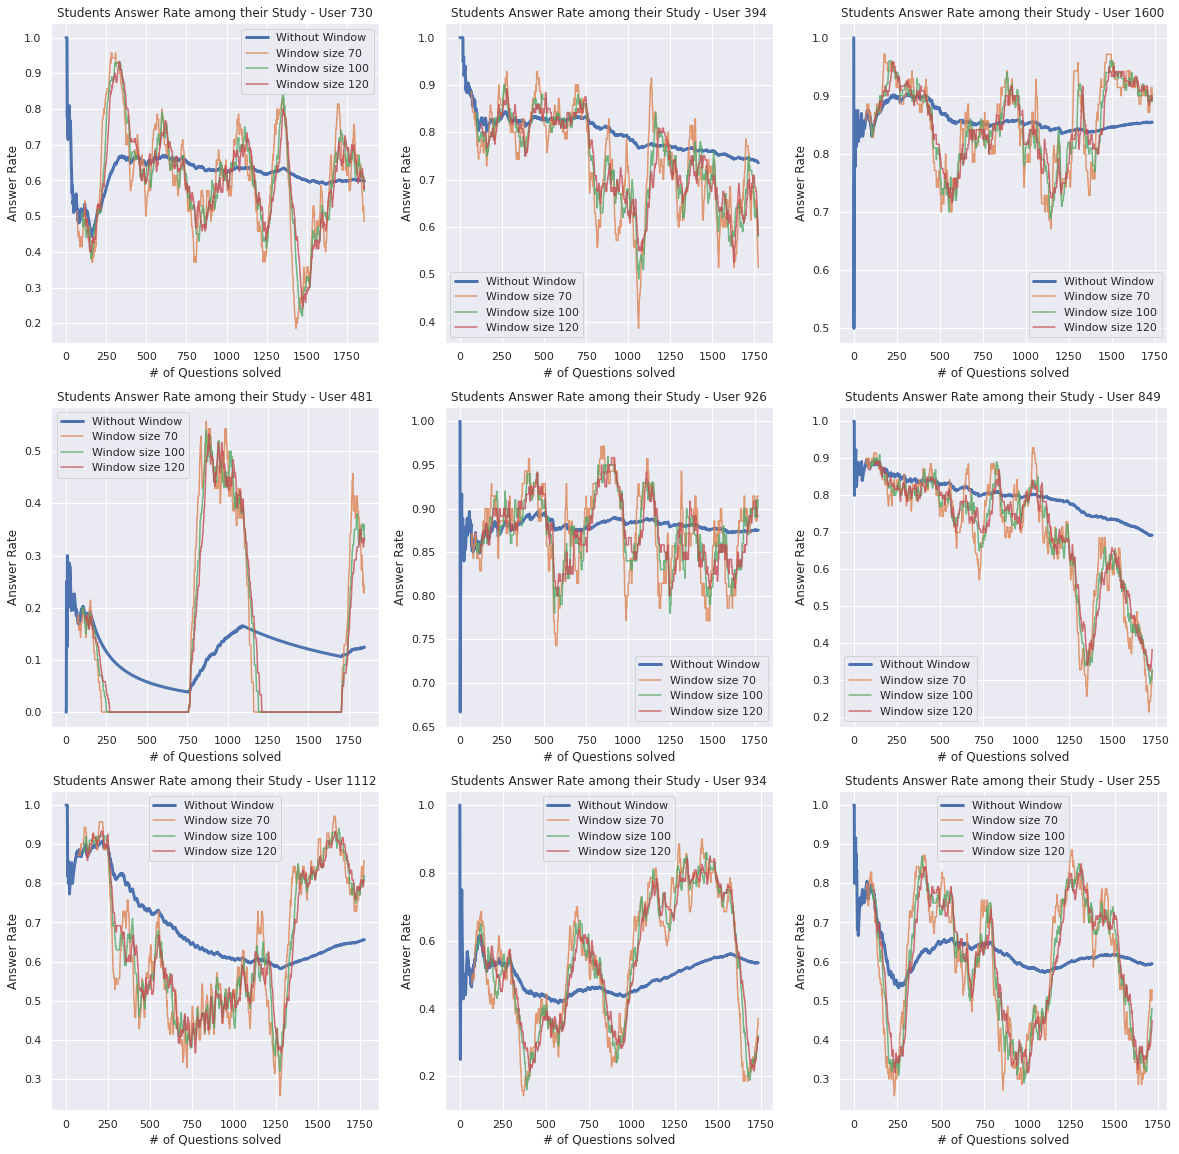

In [28]:
idx = df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx):
    
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])

# TimeStamp 분석

## 문항을 푸는 데 걸린 시간(elapsed)과 정답률 사이의 관계는?

In [29]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [98]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
df['elapsed'] = diff

In [99]:
diff

0                0.0
1                3.0
2                8.0
3                7.0
4                7.0
             ...    
2266581         24.0
2266582    6632178.0
2266583         11.0
2266584         46.0
2266585         73.0
Name: Timestamp, Length: 2266586, dtype: float64

In [100]:
elapsed_answer = df.groupby('elapsed').agg({
    'answerCode': percentile, 
    'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

In [101]:
elapsed_hist.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 541 entries, 0.0 to 594.0
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   answerCode  541 non-null    float64
 1   userID      541 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 12.7 KB


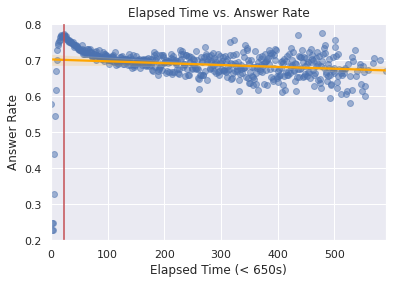

In [192]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')


## elapsed중 순수 문제를 푼 시간 (solve_elapsed)은 얼마일까?

In [37]:
def print_quantile(kk): 
    print('min : ', kk.min())    
    print('10% : ', kk.quantile(q=0.1))
    print('25% : ', kk.quantile(q=0.25))
    print('50% : ', kk.quantile(q=0.5))
    print('75% : ', kk.quantile(q=0.75))
    print('80% : ', kk.quantile(q=0.8))
    print('85% : ', kk.quantile(q=0.85))
    print('90% : ', kk.quantile(q=0.9)) 
    print('max : ', kk.max())    

    print('mean : ', kk.mean()) #52685sec = 14.6hours

In [38]:
print_quantile(df['elapsed'])

min :  0.0
10% :  3.0
25% :  13.0
50% :  37.0
75% :  135.0
80% :  237.0
85% :  1579.0
90% :  86125.0
max :  25602295.0
mean :  52685.91680792169


재접속의 기준을 4분으로 결정 (80% - 85%)
<br>
4분 이하만 문제를 제대로 푼 것으로 간주
<br>
4분 이상은 재접속으로 간주 -> frquency

In [103]:
df['solve_elapsed'] = df['elapsed'].apply(lambda x: 4*60 if x > 4*60 else x)

# 문제를 풀기 위해 접속한 frequency

## user별 재접속 횟수

In [106]:
#user별 재접속 횟수
frequency_groupby = df[df['elapsed'] > 4*60].groupby('userID').agg({
    'elapsed': 'count', #user별 재접속 횟수
    'answerCode': percentile
}).reset_index()

print(frequency_groupby['elapsed'].describe())

count    6698.000000
mean       67.363243
std        65.012648
min         1.000000
25%        15.000000
50%        46.000000
75%       103.000000
max       456.000000
Name: elapsed, dtype: float64


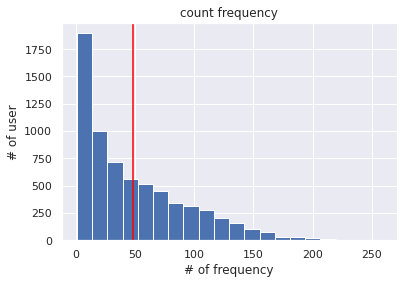

In [116]:
fig, ax = plt.subplots()
frequency_groupby['elapsed'].hist(bins=20)
ax.set_title('count frequency')
ax.set_xlabel('# of frequency')
ax.set_ylabel('# of user')
ax.axvline(frequency_groupby['elapsed'].mean(), color='red')
ax.grid(b=True)

## frequency와 정답률 관계

In [136]:
#재접속 안한 사람들 : 0 - 재접속 기준 1시간
not_frequency_groupby = df[df['elapsed'] <= 10*60].groupby('userID').agg({
    'answerCode': percentile
})


#재접속한 row들
frequency_groupby = df[df['elapsed'] > 60*60].groupby('userID').agg({
    'elapsed': 'count', #user별 재접속 횟수
    #'answerCode': percentile #user별 재접속 당시의 정답률
}).reset_index()

#재접속한 사람들 userID
frequency_userID = frequency_groupby['userID'].unique()
print('frequency_userID', len(frequency_groupby))

# =>모든 사람이 최소 한 번 이상 재접속
freq_mean = frequency_groupby.elapsed.mean()

#재접속 많이 하는 사람들 : 
frequency_userID = frequency_groupby[frequency_groupby.elapsed > freq_mean]['userID']

#재접속 조금 하는 사람들 : 1
freq_mean = frequency_groupby['elapsed'].quantile(q=0.25)

frequency_userID = frequency_groupby[frequency_groupby.elapsed > freq_mean]['userID']

df_groupby = df.groupby('userID').agg({
    'elapsed': 'count',
    'answerCode': percentile
}).reset_index()


df_groupby['frequency'] = df_groupby['userID'].apply(lambda x: 1 if x in frequency_userID else 0)

frequency_userID 6698


## 재방문 횟수에 따른 정답률

In [147]:
temp_kk = df.groupby('userID').agg({
    'assessmentItemID': 'count', 
    'answerCode': percentile
}).reset_index()

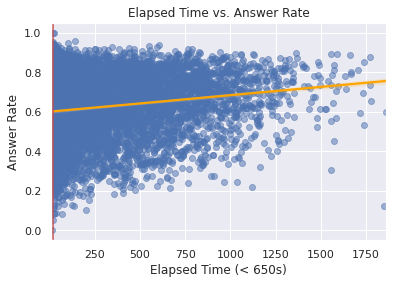

In [148]:
fig, ax = plt.subplots()
g = sns.regplot(x=temp_kk['assessmentItemID'], y=temp_kk['answerCode'],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')

## 푼 문항수에 따른 정답률 

In [194]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


In [195]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
bins = 300
itemnum_ans['bins'] = pd.cut(itemnum_ans.index,
                             [i * (itemnum_ans.index.max() - itemnum_ans.index.min()) // bins for i in range(bins)])

In [196]:
itemnum_ans = itemnum_ans.groupby('bins').mean()
itemnum_ans['mid'] = list(map(lambda x: (x.left + x.right)//2, itemnum_ans.index))

Text(0, 0.5, 'Answer Rate')

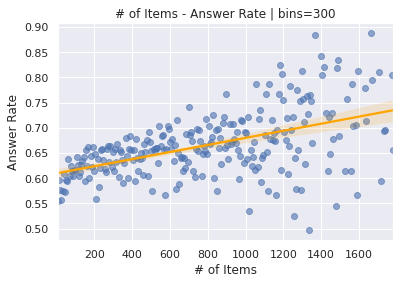

In [197]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='mid', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')